<a href="https://colab.research.google.com/github/panh1992/learning/blob/main/01_Kaggle%E6%B3%B0%E5%9D%A6%E5%B0%BC%E5%85%8B%E5%8F%B7%E6%B2%89%E8%88%B9%E5%B9%B8%E5%AD%98%E8%80%85%E9%A2%84%E6%B5%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle泰坦尼克号沉船幸存者预测 （易懂快速上手版）

## 参考

<div id="refer-anchor-1"></div>

- [1] [Kaggle泰坦尼克号（易懂快速上手版）沉船幸存者预测-二元分类](https://blog.csdn.net/weixin_42946851/article/details/84658491)

## 定义问题

&emsp;&emsp;这个项目的目的，是预测测试集中人员是否生还，也就是肯定当作二元分类的预测问题，因为是相对平衡的数据集，可以用精度作为衡量指标，而且生还和遇难并没有实质的区别（在数据层面上），所以不考虑准确度和召回率。简单点说，就是利用训练数据集，训练模型，然后用测试数据集预测模型的精度。

## 导入数据

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
# 基础模块
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# 模型预处理
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline

from sklearn.feature_selection import RFECV

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# 回归模型模块
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# 分类模型模块
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC, LinearSVC

from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

# 导入数据
train_raw = pd.read_csv('/content/drive/MyDrive/learning/input/train.csv')
test_raw = pd.read_csv('/content/drive/MyDrive/learning/input/test.csv')
# 创建新的整体列表
alldata = pd.concat([train_raw, test_raw], ignore_index=True)
# 先获得三个数据集的键值
test_index = test_raw.PassengerId
train_index = train_raw.PassengerId
alldata_index = alldata.PassengerId

## 理解分析数据

理解分析数据包括两个方面：
1. 检查数据是否有缺失，异常，大体的描述统计情况
2. 理解数据在实际场景中的含义

In [26]:
# 通过 info，describe 都能对数据集的整体有一个大概的了解
print('============   alldata.info   ================')
alldata.info()
print('============   train_raw.info ================')
train_raw.info()
print('============   test_raw.info  ================')
test_raw.info()
print('============   alldata.isnull.sum ================')
alldata.isnull().sum()

============   alldata.info   ================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
============   train_raw.info ================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  


PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [27]:
alldata.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


各数据的真实场景含义:

| 字段名称      | 字段含义      |
|:------------ |:------------|
| PassengerId  | 客户的编号，可以当作SQL中的键值，没有实际的含义
| Pclass       | 船舱的等级，一般和票价是成正比的，但是我发现不少船票价格是0英镑的乘客，可能还有一些其他的因素
| Name         | 乘客的姓名，最基本的就是姓名加一个称呼
| Sex          | 性别
| Age          | 乘客的年龄
| SibSp        | 乘客的非直系亲戚数量
| Parch        | 乘客的直系亲戚数量（父母和孩子)
| Ticket       | 船票号码，有连号的说明是一起购买的
| Fare         | 船票的价格
| Cabin        | 具体的船舱位置
| Embarked     | 登陆的港口位置 

先对这些数据有一个感性的认识，具体的影响，还要在数据的图像化中发现。真实的数据了解过程，都是一点点积累和修改的，下面就先入为主的按照各个特征写出来了。

## 清洗转换数据及特征工程

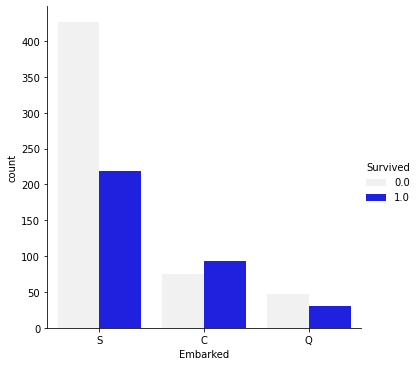

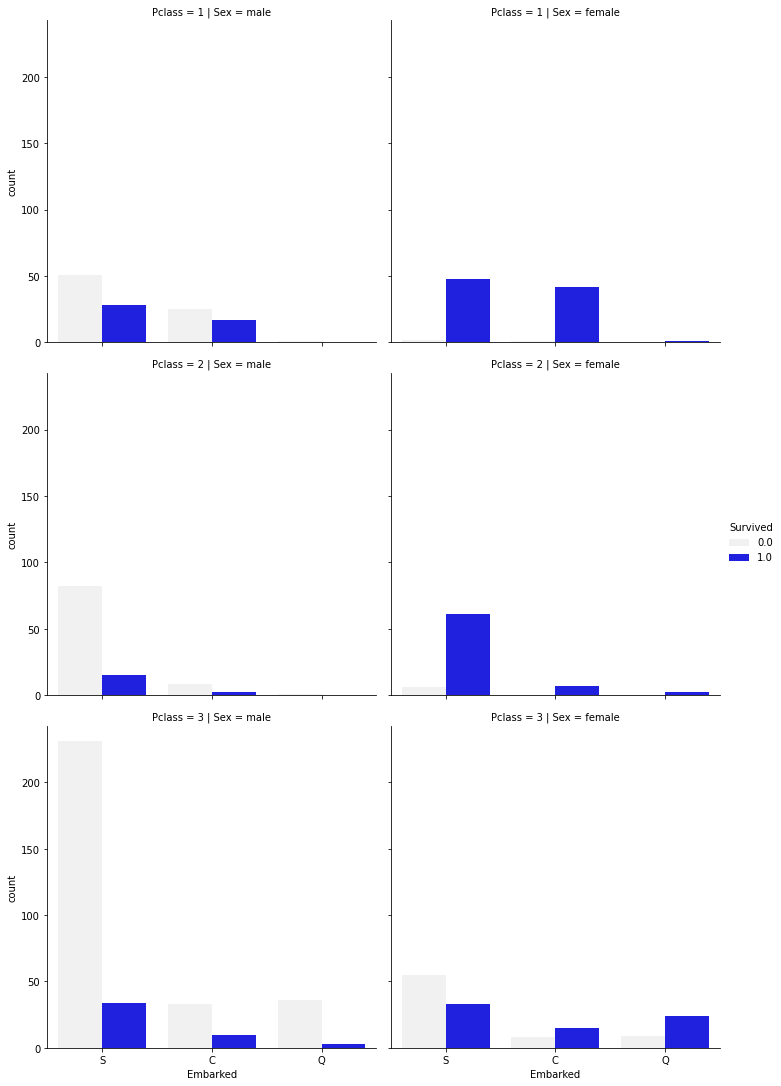

In [28]:
# Embarked:用众数补全缺失值
alldata.Embarked.fillna(alldata.Embarked.mode()[0], inplace=True)

# 可以大概看一下，不同的上传港口，对于存活率的关系。
sns.catplot('Embarked', hue='Survived', kind='count', color='b', data=alldata)
sns.catplot('Embarked', hue='Survived', row='Pclass', col='Sex', color='b', kind='count', data=alldata)

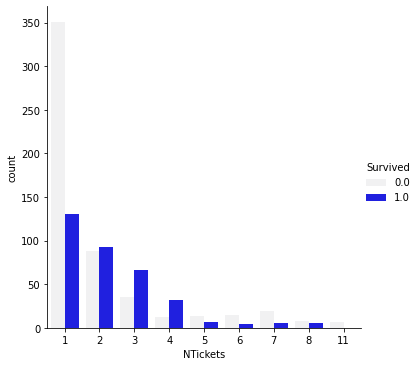

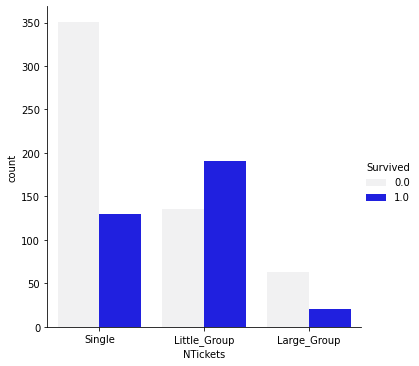

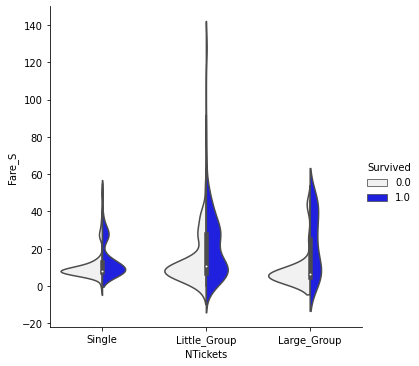

In [29]:
# Ticket和Fare：计算重票的人数,仔细点会发现，原数据中的票价，其实是和自己同票的人的总票价，所以需要重新整理一下。
alldata['NTickets'] = alldata.groupby('Ticket')['Ticket'].transform('count')
alldata['Fare_S'] = alldata.Fare / alldata.NTickets

# 用平均值填补下票价的空缺
alldata.Fare_S.fillna(alldata.Fare_S.mean(), inplace=True)

# 看一下连票对于生存率的影响
sns.catplot('NTickets', hue='Survived', kind='count', color='b', data=alldata)


# 将连票的现象，分成三个组
def NTickets_grouping(x):
    if x == 1:
        x = 'Single'
    elif 1 < x < 5:
        x = 'Little_Group'
    else:
        x = 'Large_Group'
    return x


alldata['NTickets'] = alldata.NTickets.map(NTickets_grouping)

# 你还可以深挖，比如说看看票价是字母的，票价的数字是5位数的等等的区别，通过票号推断出船舱甲板的位置的，无奈船票的排序太杂乱，实在没能找出规律。
# 查看一下船票有首字母对于存活率的影响，检查后发现没什么区别
# alldata['Ticket_withletter'] = alldata.Ticket.str.contains('^[A-Za-z]').astype(int)
# 查看下船票数字的长度对于存活率的影响，发现，船票数字为5时，存活率更高
# alldata['Ticket_Number_Len'] = alldata.Ticket.str.extract('([0-9]+$)')
# alldata['Ticket_Number_Len'] = alldata.Ticket_Number_Len.str.len()
# alldata['Ticket_Num5'] = (alldata.Ticket_Number_Len==5).astype(int)
# alldata.drop('Ticket_Number_Len', axis=1, inplace=True)
# 再看下船票整体的长度对于存活率的影响,发现数字为5和8的存活率比较高，查看后，发现8是因为船票数为5导致的
# alldata['Ticket_Len'] = alldata.Ticket.str.len()

# 根据存活率的分布，选择Fare的范围,可以直接用pd.cut/qcut结合get_dummies，我是按照存活率区间划分的，比较麻烦。
alldata['Fare_0'] = np.where(alldata.Fare_S == 0, 1, 0)
alldata['Fare_0_10'] = np.where(((alldata.Fare_S > 0) & (alldata.Fare_S <= 10)), 1, 0)
alldata['Fare_10_15'] = np.where(((alldata.Fare_S > 10) & (alldata.Fare_S <= 15)), 1, 0)
alldata['Fare_15_45'] = np.where(((alldata.Fare_S > 15) & (alldata.Fare_S <= 45)), 1, 0)
alldata['Fare_45'] = np.where(alldata.Fare_S > 45, 1, 0)

# 船票和费用的部分，我就选择了船票是否连号，和船票价格分区两个因素。
sns.catplot('NTickets', hue='Survived', kind='count', color='b', data=alldata)
sns.catplot('NTickets', y='Fare_S', hue='Survived', kind='violin', color='b', split=True, data=alldata)


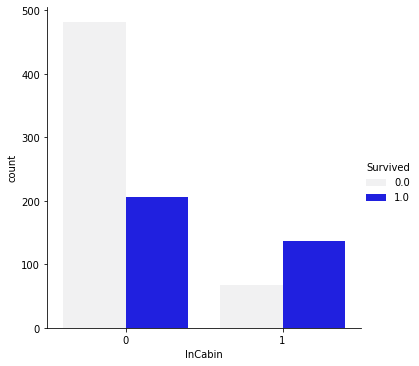

In [30]:
# Cabin:空缺值处理
alldata['InCabin'] = (alldata.Cabin.notnull()).astype(int)
sns.catplot('InCabin', hue='Survived', data=alldata, color='b', kind='count')

# 尝试（可以直接忽略）
# 我把我其他的探索也放上来哦，都是尝试，大家也以试试，熟悉熟悉正则表达式，和pandas的字符串向量处理
# 算出加班的具体甲板号，再评测不同甲板号的存活率
# alldata['Cabin_Num'] = alldata.Cabin.str.extract('([0-9]{1,3}$)')
# g = sns.FacetGrid(alldata[alldata.Cabin.notnull], col='Survived')
# g.map(sns.distplot, 'Cabin_Num', hist=False)
# 看图后，发现甲板房间号不同，确实存在明显的存活率区别,因为甲板号存在空值，所以单独提#出一个数据观察
# alldata.Cabin_Num = alldata.Cabin_Num.astype(int)
# Cabin_Num = alldata[alldata.Cabin_Num.notnull()]
# 根据房间号进行切割，看每个房间号区间的存活率，发现房号在0-20和28-40的乘客，存活率#比一般顾客的存活率要高
# Cabin_Num['Cabin_Num_Bins'] = pd.qcut(Cabin_Num.Cabin_Num, 10)
# sns.catplot('Cabin_Num_Bins', hue='Survived', data=Cabin_Num, kind='count', size=10)
# Cabin_Num.Survived[Cabin_Num.Survived == 2] = np.nan
# alldata['Cabin_Num_HighSurvived'] = (((alldata.Cabin_Num > 0) & (alldata.Cabin_Num < 20)) | ((alldata.Cabin_Num > 28) & (alldata.Cabin_Num < 40))).astype(int)
# sns.catplot('Cabin_Num_HighSurvived', hue='Survived', data=alldata, kind='count', size=10)
# 对船舱临近的进行筛选，看看存活率。可以看出，船舱连号的存活率明显低于不连号，而且在#发现在测试集的比例是不均匀的，可以作为备选的特证
# alldata['Cabin_Duplicates'] = (alldata.Cabin[alldata.Cabin.notnull()].str.contains('\s')).astype(int)
# sns.catplot('Cabin_Duplicates', hue='Survived', data=alldata, kind='count', size=10)
# alldata['Cabin_Alone'] = np.where(alldata.Cabin_Duplicates == 0, 1, 0)
# 删除多余的中间列
# alldata.drop(['Cabin_Num', 'Cabin_Num_Bins', 'Cabin_Duplicates'], axis=1, inplace=True)


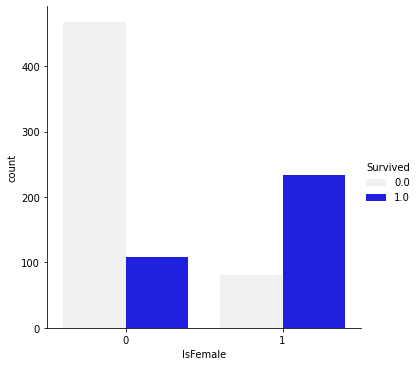

In [31]:
# Sex:直接将字符串转换成bool数组
alldata['IsFemale'] = (alldata.Sex == 'female').astype(int)
sns.catplot('IsFemale', hue='Survived', color='b', data=alldata, kind='count')

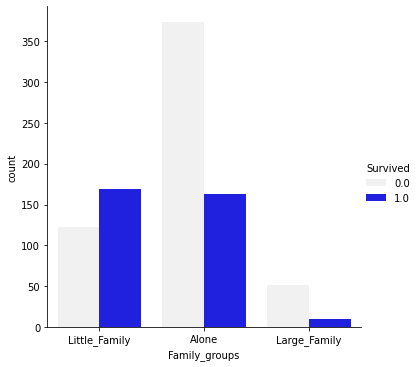

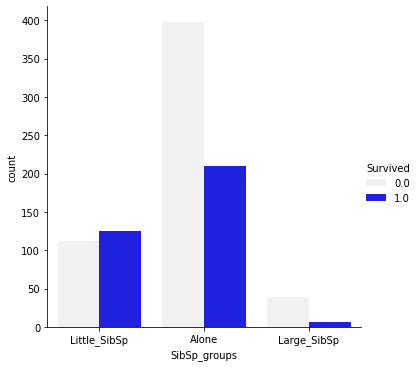

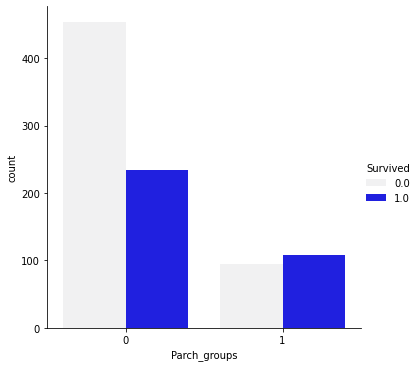

In [32]:
# SibSp和Parch
# eval是一种复合代数式算法，还有query，都比较实用，速度很快，将亲戚和亲人的项结合成一个家庭项，然后比较这三者的存活率，根据特征，各自分成几组。
alldata['Family'] = alldata.eval('SibSp+Parch+1')


def family_grouping(x):
    if x == 1:
        x = 'Alone'
    elif 1 < x < 5:
        x = 'Little_Family'
    else:
        x = 'Large_Family'
    return x


alldata['Family_groups'] = alldata.Family.map(family_grouping)


def sib_sp_grouping(x):
    if x == 0:
        x = 'Alone'
    elif 0 < x < 3:
        x = 'Little_SibSp'
    else:
        x = 'Large_SibSp'
    return x


alldata['SibSp_groups'] = alldata.SibSp.map(sib_sp_grouping)


def parch_grouping(x):
    if 0 < x < 4:
        x = 1
    else:
        x = 0
    return x


alldata['Parch_groups'] = alldata.Parch.map(parch_grouping)

sns.catplot('Family_groups', hue='Survived', data=alldata, color='b', kind='count')
sns.catplot('SibSp_groups', hue='Survived', data=alldata, color='b', kind='count')
sns.catplot('Parch_groups', hue='Survived', data=alldata, color='b', kind='count')

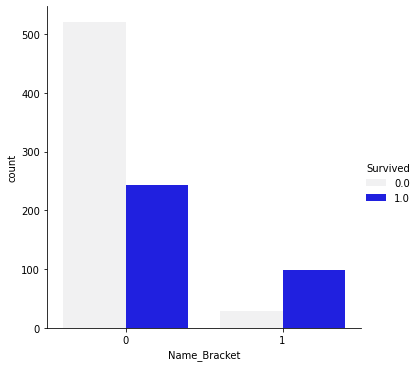

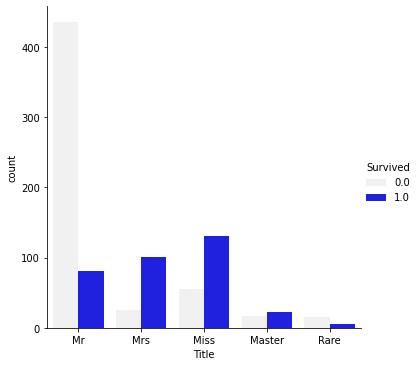

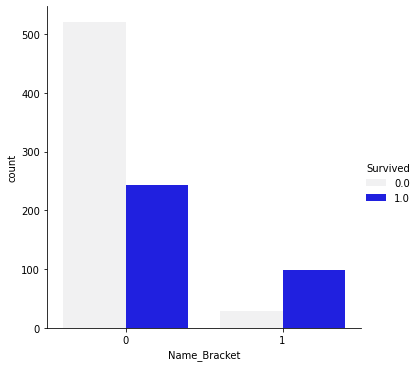

In [33]:
# Name:名字是一个信息量很大的特征，进行过很多的挖掘， 一个是名字中的称号，一个是名字的长度，还有名字中是否带有括号。
# 提取出名字中的title
alldata['Title'] = alldata.Name.str.extract('([A-Za-z]+)\.')
mapping_title = {'Capt': 'Rare', 'Lady': 'Mrs', 'Countess': 'Miss', 'Col': 'Rare', 'Don': 'Rare', 'Dr': 'Rare',
                 'Major': 'Rare', 'Rev': 'Rare', 'Sir': 'Rare', 'Jonkheer': 'Rare', 'Dona': 'Rare', 'Mlle': 'Miss',
                 'Ms': 'Miss', 'Mme': 'Mrs'}
alldata['Title'] = alldata.Title.map(lambda x: mapping_title.get(x, x))
# 对名字中有括号的进行区分
alldata['Name_Bracket'] = alldata.Name.str.contains('\([A-Za-z]+.+[A-Za-z]\)').astype(int)
sns.catplot('Name_Bracket', hue='Survived', data=alldata, color='b', kind='count')
# 对名字的每一个长度进行计算,发现名字的长度确实会影响到存活率，按大概的范围，分为六个区间
alldata['Name_Len'] = alldata.Name.str.len()
alldata['Name_Len_20_25'] = np.where(((alldata.Name_Len > 20) & (alldata.Name_Len <= 25)), 1, 0)
alldata['Name_Len_11_20'] = np.where(((alldata.Name_Len > 11) & (alldata.Name_Len <= 20)), 1, 0)
alldata['Name_Len_25_26'] = np.where(((alldata.Name_Len > 25) & (alldata.Name_Len <= 26)), 1, 0)
alldata['Name_Len_26_28'] = np.where(((alldata.Name_Len > 26) & (alldata.Name_Len <= 28)), 1, 0)
alldata['Name_Len_28_41'] = np.where(((alldata.Name_Len > 28) & (alldata.Name_Len <= 41)), 1, 0)
alldata['Name_Len_41_83'] = np.where(((alldata.Name_Len > 41) & (alldata.Name_Len <= 83)), 1, 0)

# 绘图
sns.catplot('Title', hue='Survived', data=alldata, color='b', kind='count')
sns.catplot('Name_Bracket', hue='Survived', data=alldata, color='b', kind='count')


现在除了Age，其他的特征基本算是完成了，下面利用这些特征，先进行One-Hot化，然后利用模型融合，预测出缺失的年龄值。

In [34]:
# Age:预测Age
# 准备为Age模型融合dummies
dummies = ['Embarked', 'Pclass', 'NTickets', 'Family_groups', 'SibSp_groups', 'Title']
alldata_dummies = pd.get_dummies(alldata, columns=dummies)


# 建立预测Age的模型融合模型函数
def age_predict(data, columns):
    train_set = data[data.Age.notnull()]
    test_set = data[data.Age.isnull()]
    x_train = train_set[columns]
    y_train = train_set['Age']
    x_test = test_set[columns]
    gbr = GradientBoostingRegressor()
    lr = LinearRegression()
    rfr = RandomForestRegressor()
    ml_as = [gbr, lr, rfr]
    predictdict = {}
    for mla in ml_as:
        mla.fit(x_train, y_train)
        predictdict[mla.__class__.__name__] = mla.predict(x_test)
    df_age = pd.DataFrame(predictdict)
    predict_age = df_age.mean(axis=1)
    return predict_age.values


columns_predict_age = alldata_dummies.columns.drop(
    ['Age', 'Cabin', 'Fare', 'Name', 'Parch', 'PassengerId', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Fare_S', 'Family'])
alldata_dummies['Age'][alldata_dummies.Age.isnull()] = age_predict(alldata_dummies, columns_predict_age)

##根据每一个年龄段的存活率，将年龄分成几段，同费用，可以直接使用pd.cut/qcut，会更快捷。
alldata_dummies['Age_0_8'] = np.where(((alldata_dummies.Age > -1) & (alldata_dummies.Age <= 8)), 1, 0)
alldata_dummies['Age_8_19'] = np.where(((alldata_dummies.Age > 8) & (alldata_dummies.Age <= 19)), 1, 0)
alldata_dummies['Age_19_21'] = np.where(((alldata_dummies.Age > 19) & (alldata_dummies.Age <= 21)), 1, 0)
alldata_dummies['Age_21_29'] = np.where(((alldata_dummies.Age > 21) & (alldata_dummies.Age <= 29)), 1, 0)
alldata_dummies['Age_29_36'] = np.where(((alldata_dummies.Age > 29) & (alldata_dummies.Age <= 36)), 1, 0)
alldata_dummies['Age_36_47'] = np.where(((alldata_dummies.Age > 36) & (alldata_dummies.Age <= 47)), 1, 0)
alldata_dummies['Age_47_60'] = np.where(((alldata_dummies.Age > 47) & (alldata_dummies.Age <= 60)), 1, 0)
alldata_dummies['Age_60'] = np.where(alldata_dummies.Age > 60, 1, 0)


然后再将处理后的数据集，划归到各自的训练集和测试集中

In [35]:
# 将alldata_dummies中的数据拆分开来
columns_train_test = alldata_dummies.columns.drop(
    ['Age', 'Cabin', 'Fare', 'Name', 'Parch', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Fare_S', 'Family'])

train = alldata_dummies[columns_train_test][alldata_dummies.PassengerId < 892].drop('PassengerId', axis=1)

y_train = train_raw.Survived

test = alldata_dummies[columns_train_test][alldata_dummies.PassengerId > 891].drop('PassengerId', axis=1)


## 模型选择及超参数调节

&emsp;&emsp;特征工程做好之后，会先直接走一遍Baseline，看一下各个模型对于特征工程的预测程度。然后可以选择几个准确度比较高的模型作为主要的调参对象。

Baseline初试

In [36]:
# 建立一个Baseline函数，这样做完特征工程之后，能非常方便的查看各个模型的结果，可以在里面增加训练分数，计算时间等等计算结果和数据的可视化。
def baseline(x, y):
    mla = [AdaBoostClassifier(), BaggingClassifier(), ExtraTreesClassifier(), GradientBoostingClassifier(), RandomForestClassifier(), 
           GaussianProcessClassifier(), LogisticRegressionCV(), PassiveAggressiveClassifier(), SGDClassifier(), Perceptron(), 
           BernoulliNB(), GaussianNB(), KNeighborsClassifier(), SVC(probability=True), LinearSVC(), DecisionTreeClassifier()]
    mla_compare = {}
    # 确定一下随机数，这样能保证结果的可重复性
    for alg in mla:
        alg.random_state = 0
        mla_name = alg.__class__.__name__
        score = cross_val_score(alg, x, y, cv=5)
        score_mean = round(score.mean(), 4)
        mla_compare[mla_name] = score_mean
    scores = pd.Series(mla_compare)
    return scores.sort_values(ascending=False)


baseline(train, y_train)


LogisticRegressionCV           0.8328
GradientBoostingClassifier     0.8294
RandomForestClassifier         0.8137
AdaBoostClassifier             0.8137
ExtraTreesClassifier           0.8126
LinearSVC                      0.8092
BaggingClassifier              0.7890
KNeighborsClassifier           0.7879
GaussianProcessClassifier      0.7879
SGDClassifier                  0.7800
BernoulliNB                    0.7768
DecisionTreeClassifier         0.7733
GaussianNB                     0.7655
Perceptron                     0.7498
PassiveAggressiveClassifier    0.7249
SVC                            0.7026
dtype: float64

通过上面的结果，我们可以选择几个比较好的模型，进行下一步的调参。

超参数调节

In [37]:
class SubestimatorOfStacking():
    '''单个模型调参，控制特征量进行预测探索，保存预测文档，创建Stacking子特征的机器学习辅助类
    参数
    ---------------
    alg:要进行网格搜索的评估器
    param_grid:进行超参数调优的参数网格，建议每次调参使用两维的参数
    random_state:随机数控制，默认为0，利用随机数参数，能控制结果的稳定性
    n_jobs:使用计算的cpu，默认为None，-1是启动所在电脑的全部cpu内核
    ----------------
    方法
    ----------------
    fit(self,X,y,rfecv=False):根据param_grid提供的参数网格，对训练集进行网格搜索，计算后，自动输出最优的测试分数，模型参数及参数热图。
    rfecv是在网格搜索后，是否使用递归特征消除（recursive feature elimination，RFE），对特征进行迭代筛选。
    stacking(self,X,y,X_test,n_folds=5):对特定的模型，进行staking的预准备，输出为train的一列n_folds预测特征，和test的一列n_folds的预测均值。
    fit_predict(self,X,y,test):利用fit之后的最优模型，训练新的数据集，并输出预测值。
    fit_predict_submit(self,X,y,test,test_index,reduce_features=0,from_importancest=False):利用fit选择出的模型，对数据特征进行筛选，训练，并将预测结果保存到当前目录下。
    test_index是测试集的键，reduce_features是进行此次测试时，选择减少的特征，from_importancest是选择从哪里减少特征，True是从最重要的特征方向减少，适合于各个特征重要性差不多的数据集，
    False是从最不重要的特征方向进行减少，类似于RFECV的功能。
    '''

    def __init__(self, alg, param_grid, random_state=0, n_jobs=None):
        self.alg = alg
        self.param_grid = param_grid
        self.random_state = random_state
        self.alg.random_state = self.random_state
        self.n_jobs = n_jobs

    def fit(self, x, y, rfecv=False):
        self.x_train = x
        self.y_train = y
        self.rfecv = rfecv
        self.grid = GridSearchCV(self.alg, self.param_grid, cv=5)
        self.grid.n_jobs = self.n_jobs
        self.grid.fit(self.x_train, self.y_train)
        self.best_estimator_ = self.grid.best_estimator_
        self.best_params_ = self.grid.best_params_
        print('The best score after GridSearchCV is ' + str(self.grid.best_score_) + '.')
        if self.rfecv:
            self.rfecv = RFECV(self.best_estimator_, min_features_to_select=int(self.x_train.shape[1] / 2), cv=5)
            self.rfecv.fit(self.x_train, self.y_train)
            self.best_features_ = self.x_train.columns[self.rfecv.get_support()]
            print('The best score after RFECV is ' + str(self.rfecv.grid_scores_.max()) + '.')
            print('The number of selected features is ' + str(self.rfecv.n_features_) + '.')
            print('If you want get the top features,please use self.best_features_.')
        self.cv_results_ = pd.DataFrame(self.grid.cv_results_)
        self.cv_results_heatmap_ = self.cv_results_.pivot_table(values='mean_test_score',
                                                                columns=self.cv_results_.columns[4],
                                                                index=self.cv_results_.columns[5])
        sns.heatmap(self.cv_results_heatmap_, annot=True)
        print('The best params is {}'.format(self.grid.best_params_))
        return self

    def stacking(self, x, y, x_test, n_folds=5):
        self.x_train = x.values
        self.y_train = y
        self.x_test = x_test.values
        self.n_folds = n_folds
        ntrain = self.x_train.shape[0]
        ntest = self.x_test.shape[0]
        self.oof_train = np.zeros((ntrain,))
        self.oof_test = np.zeros((ntest,))
        oof_test_df = np.empty((self.n_folds, ntest))
        kf = KFold(n_splits=self.n_folds, random_state=self.random_state)

        for i, (train_index, test_index) in enumerate(kf.split(self.x_train)):
            x_tr = self.x_train[train_index]
            y_tr = self.y_train[train_index]
            x_te = self.x_train[test_index]

            self.best_estimator_.fit(x_tr, y_tr)
            y_te = self.best_estimator_.predict(x_te)
            self.oof_train[test_index] = y_te
            oof_test_df[i, :] = self.best_estimator_.predict(x_test)
        self.oof_test = oof_test_df.mean(axis=0)
        self.oof_train = self.oof_train.reshape(-1, 1)
        self.oof_test = self.oof_test.reshape(-1, 1)
        return self.oof_train, self.oof_test

    def fit_predict(self, x, y, test):
        self.best_estimator_.fit(x, y)
        return self.best_estimator_.predict(test)

    def fit_predict_submit(self, x, y, test, test_index, reduce_features=0, from_importancest=False):
        self.from_importancest = from_importancest
        self.features_ = pd.Series(self.rfecv.estimator_.feature_importances_, index=self.best_features_).sort_values(
            ascending=self.from_importancest)
        self.reduce_features = reduce_features
        self.submit_features_len_ = len(self.features_.index) - self.reduce_features
        self.columns = self.features_.index[:self.submit_features_len_]
        self.best_estimator_.fit(x[self.columns], y)
        self.prediction = self.best_estimator_.predict(test[self.columns])
        self.submit = pd.DataFrame({'PassengerId': test_index, 'Survived': self.prediction})
        return self.submit.to_csv('sub.csv', index=False)


先选一个随机数森林进行测试

The best score after GridSearchCV is 0.8350009415604795.
The best score after RFECV is 0.8350009415604795.
The number of selected features is 44.
If you want get the top features,please use self.best_features_.
The best params is {'max_depth': 5, 'n_estimators': 100, 'random_state': 0}


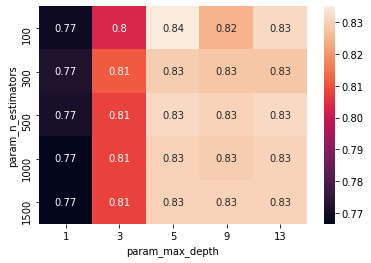

In [38]:
###选择参数的范围，建议两个参数，先第一步大范围的，然后再根据结构，缩小参数的范围
random_state_grid = [0]

param_grid_RandomForestClassifier = {'n_estimators': [100, 300, 500, 1000, 1500], 'max_depth': [1, 3, 5, 9, 13], 'random_state': random_state_grid}

rfc = SubestimatorOfStacking(RandomForestClassifier(), param_grid_RandomForestClassifier).fit(train, y_train, rfecv=True)

这个类里面的网格搜索，特征选择评估器的属性，都能读出，能很方便的得到，你想要的其他属性。
其实到这一步，就能得到一个不错的模型了，如果进一步的了解，就可以再用voting，boosting或者staking，blending的模型融合了，

下面介绍stacking的方法，然后再简单介绍一下votingclassier，其实随机树（RandomForestClassifier）用到的就是voting，而梯度提升机（GradientBoostingClassifier）用到的就是boosting。只不过他们的子评估器是n个决策树。

## 模型融合

先为每一类器训练模型，优化参数，调参的过程。<br/>
各评估器调节参数,向量机分类器因为是根据边界点决定范围的，所以它不存在判断哪个特征重要不重要的问题，因为它的rfecv项应该设置为False，不然会报错。<br/>
然后根据优化后的模型，得到第一层数据集

1. 随机森林模型

The best score after GridSearchCV is 0.8350009415604795.
The best score after RFECV is 0.8350009415604795.
The number of selected features is 44.
If you want get the top features,please use self.best_features_.
The best params is {'max_depth': 5, 'n_estimators': 100, 'random_state': 0}


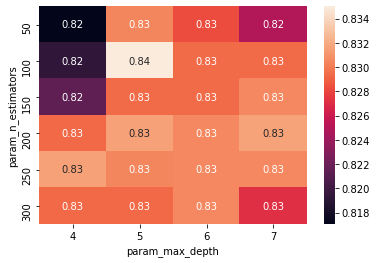

In [39]:
param_grid_RandomForestClassifier = {'n_estimators': [50, 100, 150, 200, 250, 300], 'max_depth': [4, 5, 6, 7],
                                     'random_state': random_state_grid}

rfc = SubestimatorOfStacking(RandomForestClassifier(), param_grid_RandomForestClassifier).fit(train, y_train, rfecv=True)

rfc_train, rfc_test = rfc.stacking(train, y_train, test)

2. 极端随机树

The best score after GridSearchCV is 0.8350009415604797.
The best score after RFECV is 0.8361245370660976.
The number of selected features is 43.
If you want get the top features,please use self.best_features_.
The best params is {'max_depth': 5, 'n_estimators': 100, 'random_state': 0}


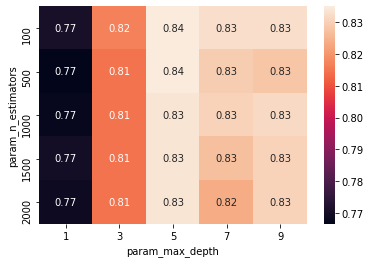

In [40]:
param_grid_ExtraTreesClassifier = {'n_estimators': [100, 500, 1000, 1500, 2000], 'max_depth': [1, 3, 5, 7, 9],
                                   'random_state': random_state_grid}

etc = SubestimatorOfStacking(ExtraTreesClassifier(), param_grid_ExtraTreesClassifier).fit(train, y_train, rfecv=True)

etc_train, etc_test = etc.stacking(train, y_train, test)

3. AdaBoostClassifier

The best score after GridSearchCV is 0.8260184545853996.
The best score after RFECV is 0.8260184545853996.
The number of selected features is 22.
If you want get the top features,please use self.best_features_.
The best params is {'learning_rate': 0.01, 'n_estimators': 1000, 'random_state': 0}


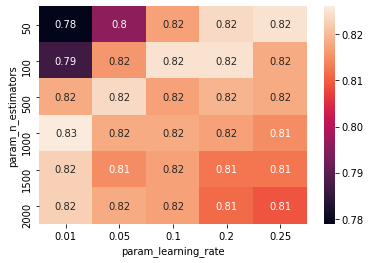

In [41]:
param_grid_AdaBoostClassifier = {'learning_rate': [.01, 0.05, .1, .2, 0.25],
                                 'n_estimators': [50, 100, 500, 1000, 1500, 2000], 'random_state': random_state_grid}

abc = SubestimatorOfStacking(AdaBoostClassifier(), param_grid_AdaBoostClassifier).fit(train, y_train, rfecv=True)

abc_train, abc_test = abc.stacking(train, y_train, test)

4. 梯度提升决策树模型

The best score after GridSearchCV is 0.8294206264515724.
The best score after RFECV is 0.8305442219571904.
The number of selected features is 43.
If you want get the top features,please use self.best_features_.
The best params is {'learning_rate': 0.01, 'n_estimators': 1500, 'random_state': 0}


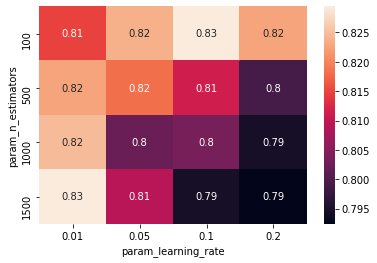

In [42]:
param_grid_GradientBoostingClassifier = {'learning_rate': [.01, .05, .1, .2], 'n_estimators': [100, 500, 1000, 1500],
                                         'random_state': random_state_grid}

gbc = SubestimatorOfStacking(GradientBoostingClassifier(), param_grid_GradientBoostingClassifier).fit(train, y_train, rfecv=True)

gbc_train, gbc_test = gbc.stacking(train, y_train, test)

5. SVC 模型

The best score after GridSearchCV is 0.832741196409516.
The best params is {'C': 3, 'gamma': 0.01, 'random_state': 0}


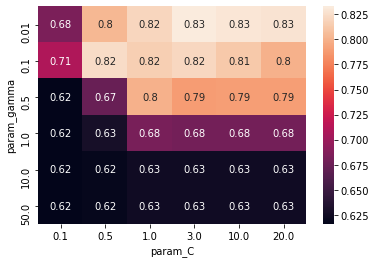

In [43]:
param_grid_SVC = {'C': [0.1, .5, 1, 3, 10, 20], 'gamma': [0.01, 0.1, 0.5, 1, 10, 50], 'random_state': random_state_grid}

svc = SubestimatorOfStacking(SVC(), param_grid_SVC).fit(train, y_train)

svc_train, svc_test = svc.stacking(train, y_train, test)

将这五组数据统一到训练和测试集，我们可以看一下，这个的预测结果的相关性，评估的好坏，当然是越不相关越好，因为这样才能让各个模型挖掘出更多的信息


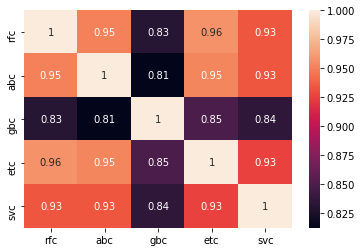

In [44]:
base_train = pd.DataFrame(
    {'rfc': rfc_train.ravel(), 'abc': abc_train.ravel(), 'gbc': gbc_train.ravel(), 'etc': etc_train.ravel(),
     'svc': svc_train.ravel()})
sns.heatmap(base_train.corr(), annot=True)

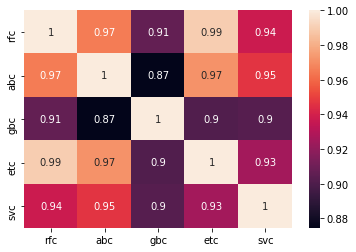

In [45]:
base_test = pd.DataFrame(
    {'rfc': rfc_test.ravel(), 'abc': abc_test.ravel(), 'gbc': gbc_test.ravel(), 'etc': etc_test.ravel(),
     'svc': svc_test.ravel()})
sns.heatmap(base_test.corr(), annot=True)

有了第一层数据，就可以继续用SubestimatorOfStacking类，选择第二层的评估器，参数调优和特征选择了。

The best score after GridSearchCV is 0.8350009415604795.
The best score after RFECV is 0.8350009415604795.
The number of selected features is 3.
If you want get the top features,please use self.best_features_.
The best params is {'learning_rate': 0.01, 'n_estimators': 50, 'random_state': 0}


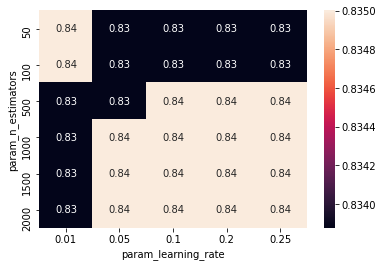

In [47]:
# 第二层评估器选择，调优及特征选择
abc_stacking = SubestimatorOfStacking(AdaBoostClassifier(), param_grid_AdaBoostClassifier).fit(base_train, y_train, rfecv=True)

In [49]:
# 模拟好之后，直接提交结果
abc_stacking.fit_predict_submit(base_train, y_train, base_test, test_index)

解释一下，通过stacking的方式，就有很多维的调节参数的形式，去发现最合适的特征，模型和参数组合。最合适训练集的模型，并不代表最合适测试集，而测试集的大小，又决定了这个不合适的程度，对于真实的应用，近似的正确就好，但是对于竞赛来说，因为测试集，很多时候会为了迎合测试集，而选择了精确的错误。

voting

voting主要分有hard和soft两种，hard模式是根据结果进行投票选择，而soft是根据每一个评估器算出来的每个样本的概率求和平均，再得出预测，所以soft情形下，支持向量机是不能使用的，因为它计算不出估计值。

In [50]:
# 通过voting进行评估。
vc = VotingClassifier([('rfc', rfc.best_estimator_), ('gbc', gbc.best_estimator_), ('abc', abc.best_estimator_),
                       ('etc', etc.best_estimator_), ('svc', svc.best_estimator_)], weights=[1, 1, 1, 1, 1], voting='hard')
score = cross_val_score(vc, train, y_train, cv=5)
score.mean()

0.8349883874207521

In [ ]:
# 可以试一下soft，会直接出错，将支持向量机剔除就好了
vc = VotingClassifier([('rfc', rfc.best_estimator_), ('gbc', gbc.best_estimator_), ('abc', abc.best_estimator_),
                       ('etc', etc.best_estimator_)], weights=[1, 1, 1, 1], voting='soft')
score = cross_val_score(vc, train, y_train, cv=5)
score.mean()

## 提交结果

In [52]:
vc.fit(train,y_train)
prediction=vc.predict(test)
submission=pd.DataFrame({'PassengerId':test_raw.PassengerId,'Survived':prediction})
submission.to_csv('/content/drive/MyDrive/learning/input/submission.csv',index=False)